In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import rasterio as rio
from scipy.stats import pearsonr

In [3]:
# DATA = '../data/lite'
DATA = '../data/full/exp'
# mat_data_dir = os.path.join(DATA, 'mat')
mat_data_dir = DATA
mat_data_files = [os.path.join(mat_data_dir, file).replace('\\', '/') 
                  for file in os.listdir(mat_data_dir)]
matdf = [pd.read_csv(file, sep='\s+') for file in mat_data_files]
matdf = pd.concat(matdf, sort=False)
matdf = matdf.rename(str.lower, axis='columns')
sep = matdf.loc[matdf['month'] == 9]
sep.head()

,year,month,day,hour,minute,n_cluster,lon,lat,ind_x,ind_y,reflect,yyyyy_xx1,yyyyy_xx2,yyyyyyy_xx3,yyy_xx4,yyy_xx5,river,cxe,precipit,vil
0,2014.0,9.0,15.0,6.0,0.0,9.0,-60.8114,-3.7489,79.0,150.0,20.4531,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.8446,0.2019
1,2014.0,9.0,15.0,6.0,0.0,9.0,-60.7914,-3.7489,80.0,150.0,24.7031,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.3909,0.3308
2,2014.0,9.0,15.0,6.0,0.0,9.0,-60.7714,-3.7489,81.0,150.0,22.6719,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.7394,0.2610
3,2014.0,9.0,15.0,6.0,0.0,9.0,-60.8314,-3.7689,78.0,151.0,25.2969,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.6240,0.3249
4,2014.0,9.0,15.0,6.0,0.0,9.0,-60.8114,-3.7689,79.0,151.0,26.7812,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.3109,0.4041


In [6]:
aggregated = sep.groupby(['hour']).agg({
    'reflect': ['min', 'mean', 'max'], 
    'precipit': ['min', 'mean', 'max'],
    'yyyyy_xx1': ['sum'], 
    'yyyyy_xx2': ['sum'],
    'yyyyyyy_xx3': ['sum'],
    'yyy_xx4': ['sum'],
    'yyy_xx5': ['sum']
})
aggregated.head()

reflect                     precipit                      yyyyy_xx1  \
          min       mean      max      min       mean       max       sum   
hour                                                                        
16.0  20.0156  25.821405  38.7656   0.7897   3.591449   21.6373       0.0   
17.0  20.0000  27.598658  49.3281   0.7878   6.659418  113.1724       4.0   
18.0  19.9688  28.696703  51.6562   0.7841   8.464245  162.9733      16.0   
19.0  19.9688  30.941200  52.6250   0.7841  13.939154  189.6784      33.0   
20.0  19.9844  30.848820  50.8906   0.8109  13.516923  144.5550      13.0   

     yyyyy_xx2 yyyyyyy_xx3 yyy_xx4 yyy_xx5  
           sum         sum     sum     sum  
hour                                        
16.0       0.0         0.0     0.0     0.0  
17.0       1.0         7.0     1.0     2.0  
18.0      26.0        23.0    31.0    25.0  
19.0     104.0        42.0    55.0    47.0  
20.0     114.0        19.0    22.0    17.0

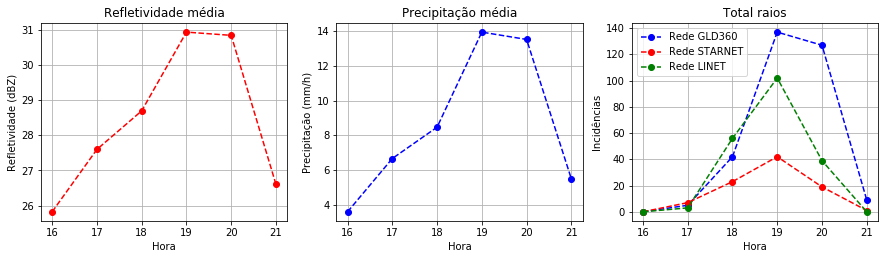

In [18]:
fig = plt.figure(figsize=(15, 8))
hours = aggregated.index.to_list()
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
mean_reflect = aggregated.reflect['mean'].to_list()
ax1.set_title('Refletividade média')
ax1.set_xlabel('Hora')
ax1.set_ylabel('Refletividade (dBZ)')
ax1.plot(hours, mean_reflect, 'go--', color='r')
ax1.grid()

ax2 = fig.add_subplot(gs[0, 1])
mean_precipit = aggregated.precipit['mean'].to_list()
ax2.set_title('Precipitação média')
ax2.set_xlabel('Hora')
ax2.set_ylabel('Precipitação (mm/h)')
ax2.plot(hours, mean_precipit, 'go--', color='b')
ax2.grid()

##ligning
ax3 = fig.add_subplot(gs[0, 2])
total_light1 = aggregated.yyyyy_xx1['sum']+aggregated.yyyyy_xx2['sum']
total_light1 = total_light1.to_list()
ax3.set_title('Total raios')
ax3.set_xlabel('Hora')
ax3.set_ylabel('Incidências')
ax3.plot(hours, total_light1, 'go--', color='b', label='Rede GLD360')
ax3.grid()

total_light1 = aggregated.yyyyyyy_xx3['sum']
total_light1 = total_light1.to_list()
ax3.set_title('Total raios')
ax3.set_xlabel('Hora')
ax3.set_ylabel('Incidências')
ax3.plot(hours, total_light1, 'go--', color='r', label='Rede STARNET')
ax3.grid()

total_light1 = aggregated.yyy_xx4['sum']+aggregated.yyy_xx5['sum']
total_light1 = total_light1.to_list()
ax3.set_title('Total raios')
ax3.set_xlabel('Hora')
ax3.set_ylabel('Incidências')
ax3.plot(hours, total_light1, 'go--', color='g', label='Rede LINET')
ax3.grid()
ax3.legend()
## end lightning

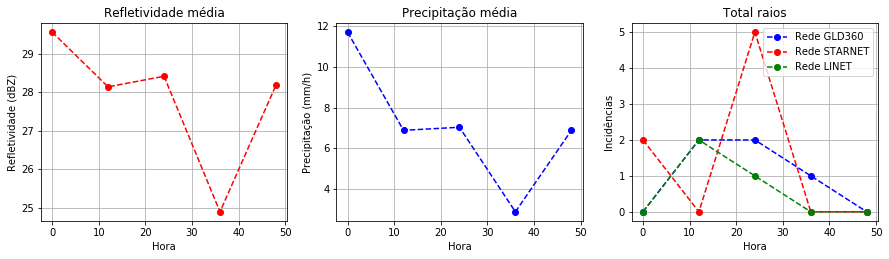

In [52]:
# sep = sep.loc[(sep['hour'] >= 0) & (sep['hour'] < 22)]
sep = sep.loc[(sep['hour'] == 17)]

aggregated = sep.groupby(['minute']).agg({
    'reflect': ['min', 'mean', 'max'], 
    'precipit': ['min', 'mean', 'max'], 
    'yyyyy_xx1': ['sum'], 
    'yyyyy_xx2': ['sum'],
    'yyyyyyy_xx3': ['sum'],
    'yyy_xx4': ['sum'],
    'yyy_xx5': ['sum'],
})


fig = plt.figure(figsize=(15, 8))
hours = aggregated.index.to_list()
gs = gridspec.GridSpec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
mean_reflect = aggregated.reflect['mean'].to_list()
ax1.set_title('Refletividade média')
ax1.set_xlabel('Hora')
ax1.set_ylabel('Refletividade (dBZ)')
ax1.plot(hours, mean_reflect, 'go--', color='r')
ax1.grid()

ax2 = fig.add_subplot(gs[0, 1])
mean_precipit = aggregated.precipit['mean'].to_list()
ax2.set_title('Precipitação média')
ax2.set_xlabel('Hora')
ax2.set_ylabel('Precipitação (mm/h)')
ax2.plot(hours, mean_precipit, 'go--', color='b')
ax2.grid()

##ligning
ax3 = fig.add_subplot(gs[0, 2])
total_light1 = aggregated.yyyyy_xx1['sum']+aggregated.yyyyy_xx2['sum']
total_light1 = total_light1.to_list()
ax3.set_title('Total raios')
ax3.set_xlabel('Hora')
ax3.set_ylabel('Incidências')
ax3.plot(hours, total_light1, 'go--', color='b', label='Rede GLD360')
ax3.grid()

total_light1 = aggregated.yyyyyyy_xx3['sum']
total_light1 = total_light1.to_list()
ax3.set_title('Total raios')
ax3.set_xlabel('Hora')
ax3.set_ylabel('Incidências')
ax3.plot(hours, total_light1, 'go--', color='r', label='Rede STARNET')
ax3.grid()

total_light1 = aggregated.yyy_xx4['sum']+aggregated.yyy_xx5['sum']
total_light1 = total_light1.to_list()
ax3.set_title('Total raios')
ax3.set_xlabel('Hora')
ax3.set_ylabel('Incidências')
ax3.plot(hours, total_light1, 'go--', color='g', label='Rede LINET')
ax3.grid()
ax3.legend()
## end lightning

In [57]:
sth = sep.groupby(['hour']).agg({
    'reflect': ['min', 'mean', 'max'], 
    'precipit': ['min', 'mean', 'max'], 
    'yyyyy_xx1': ['sum'], 
    'yyyyy_xx2': ['sum'],
    'yyyyyyy_xx3': ['sum'],
    'yyy_xx4': ['sum'],
    'yyy_xx5': ['sum'],
})
sth

reflect                     precipit                      yyyyy_xx1  \
          min       mean      max      min       mean       max       sum   
hour                                                                        
16.0  20.0156  25.821405  38.7656   0.7897   3.591449   21.6373       0.0   
17.0  20.0000  27.598658  49.3281   0.7878   6.659418  113.1724       4.0   
18.0  19.9688  28.696703  51.6562   0.7841   8.464245  162.9733      16.0   
19.0  19.9688  30.941200  52.6250   0.7841  13.939154  189.6784      33.0   
20.0  19.9844  30.848820  50.8906   0.8109  13.516923  144.5550      13.0   
21.0  19.9688  26.605547  47.0156   0.8109   5.487279   78.7821       3.0   

     yyyyy_xx2 yyyyyyy_xx3 yyy_xx4 yyy_xx5  
           sum         sum     sum     sum  
hour                                        
16.0       0.0         0.0     0.0     0.0  
17.0       1.0         7.0     1.0     2.0  
18.0      26.0        23.0    31.0    25.0  
19.0     104.0        42.0    55.0    47.0  
20.0     114.0        19.0    22.0    17.0  
21.0       6.0         1.0     0.0     0.0

In [59]:
stm = sep.groupby(['hour', 'minute']).agg({
    'reflect': ['min', 'mean', 'max'], 
    'precipit': ['min', 'mean', 'max'], 
    'yyyyy_xx1': ['sum'], 
    'yyyyy_xx2': ['sum'],
    'yyyyyyy_xx3': ['sum'],
    'yyy_xx4': ['sum'],
    'yyy_xx5': ['sum'],
})
stm

reflect                     precipit                       \
                 min       mean      max      min       mean       max   
hour minute                                                              
16.0 12.0    20.4062  28.289064  36.2188   0.8385   4.858843   14.5193   
     24.0    20.0156  27.627740  38.7656   0.7897   5.242667   21.6373   
     36.0    20.0312  24.236062  37.3594   0.7916   2.379917   17.3596   
     48.0    20.1250  24.864153  34.2344   0.8031   2.671633   10.6403   
17.0 0.0     20.3281  29.570478  49.3281   0.8285  11.707137  113.1724   
     12.0    20.1875  28.143968  45.1250   0.8109   6.882369   58.5887   
     24.0    20.0625  28.420506  44.5781   0.7954   7.033787   53.7788   
     36.0    20.2031  24.889068  40.5000   0.8128   2.879681   28.3915   
     48.0    20.0000  28.187506  46.8125   0.7878   6.878970   76.3149   
18.0 0.0     20.0156  27.145283  46.0781   0.7897   6.830485   68.0224   
     12.0    20.0469  26.863956  44.5156   0.7935   5.394811   53.2549   
     24.0    20.0469  29.067188  45.7812   0.7935   7.982566   64.9317   
     36.0    19.9688  29.561794  46.7188   0.7841   9.576738   75.2025   
     48.0    20.0312  29.704443  51.6562   0.7916  11.036620  162.9733   
19.0 0.0     20.0156  31.469268  49.5625   0.7897  14.686897  117.4044   
     12.0    19.9688  31.605180  52.6250   0.7841  15.514165  189.6784   
     24.0    19.9688  31.121021  50.6719   0.7841  14.394130  139.6858   
     36.0    19.9688  30.401127  49.5000   0.7841  12.119762  116.2607   
     48.0    20.1250  30.396847  51.0938   0.8031  13.576295  149.2283   
20.0 0.0     20.5469  33.733786  48.8438   0.8568  18.494572  104.9035   
     12.0    20.0625  33.702359  48.4688   0.8109  18.773496   98.9190   
     24.0    20.2500  33.483644  50.8906   0.8187  19.458449  144.5550   
     36.0    20.1406  28.043350  46.7344   0.8148   7.955099   75.3867   
     48.0    19.9844  25.632276  39.9375   0.8713   3.735698   25.9970   
21.0 0.0     20.1094  26.739578  47.0156   0.8109   7.847136   78.7821   
     12.0    19.9688  27.139460  43.0312   0.8167   5.665219   42.2067   
     24.0    20.1406  26.493190  41.7969   1.1700   4.217774   34.7865   
     36.0    20.4219  25.459969  29.5469   1.2227   2.899456    5.1060   

            yyyyy_xx1 yyyyy_xx2 yyyyyyy_xx3 yyy_xx4 yyy_xx5  
                  sum       sum         sum     sum     sum  
hour minute                                                  
16.0 12.0         0.0       0.0         0.0     0.0     0.0  
     24.0         0.0       0.0         0.0     0.0     0.0  
     36.0         0.0       0.0         0.0     0.0     0.0  
     48.0         0.0       0.0         0.0     0.0     0.0  
17.0 0.0          0.0       0.0         2.0     0.0     0.0  
     12.0         2.0       0.0         0.0     0.0     2.0  
     24.0         1.0       1.0         5.0     1.0     0.0  
     36.0         1.0       0.0         0.0     0.0     0.0  
     48.0         0.0       0.0         0.0     0.0     0.0  
18.0 0.0          0.0       1.0         1.0     0.0     0.0  
     12.0         1.0       0.0         0.0     0.0     0.0  
     24.0         3.0       2.0         3.0     8.0     7.0  
     36.0         1.0       1.0         7.0     3.0     9.0  
     48.0        11.0      22.0        12.0    20.0     9.0  
19.0 0.0          3.0      32.0         8.0    10.0     7.0  
     12.0        12.0      28.0         4.0    21.0    12.0  
     24.0         8.0      15.0        20.0    18.0    21.0  
     36.0         7.0      11.0         5.0     2.0     6.0  
     48.0         3.0      18.0         5.0     4.0     1.0  
20.0 0.0          0.0       8.0         1.0     4.0     0.0  
     12.0         5.0      30.0         6.0     5.0     4.0  
     24.0         2.0      52.0         7.0     7.0    10.0  
     36.0         6.0      24.0         5.0     6.0     3.0  
     48.0         0.0       0.0         0.0     0.0     0.0  
21.0 0.0          3.0       6.0         1.0 

In [129]:
ref = {}
pre = {}
for i, row in stm.reflect.iterrows():
    ref[i] = row['mean']

for i, row in stm.precipit.iterrows():
    pre[i] = row['mean']

In [100]:
list(ref.keys())[0][0]

16.0

[]

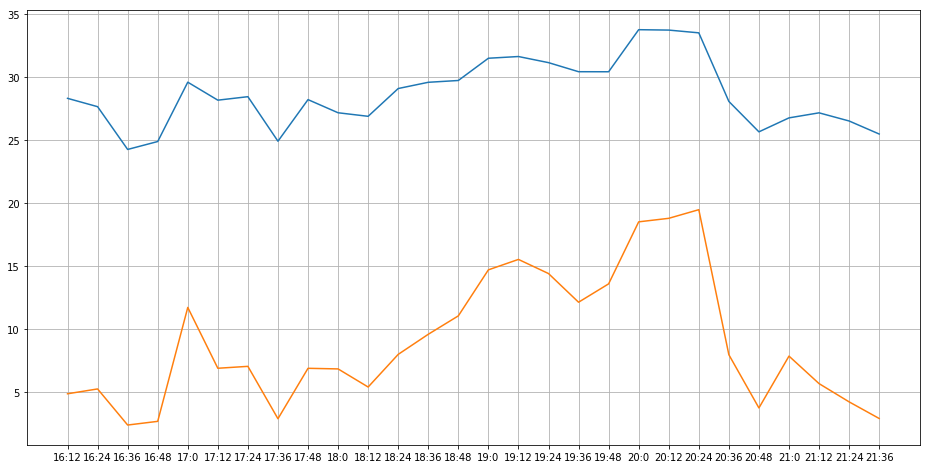

In [132]:

fig, ax = plt.subplots(figsize=(16, 8))
x, y = [], []
for key in ref.keys():
    x.append('{}:{}'.format(int(key[0]), int(key[1])))
    y.append(ref[key])

ax.plot(x, y)

x, y = [], []
for key in pre.keys():
    x.append('{}:{}'.format(int(key[0]), int(key[1])))
    y.append(pre[key])
    
ax.plot(x, y)
plt.grid()
plt.plot()